# MFE selecting data
This script uses the API from copernicus to automatically download data over a specific area and then save only the pixels under the shape defined by the user

## Imports

In [1]:
import geopandas as gpd
import os
import requests
import osgeo
import rasterio as rio
import matplotlib.pyplot as plt
import numpy as np
import glob
import pandas as pd
import ipywidgets as widgets
from src.utils import clean, resample

## Open json files
The user needs to define a geojson file, this file will then be compared with the data on Copernicus as a filter for selecting data. Enter the path to the geojson file below or leave empty to select default file

In [2]:
default_json_path = os.path.join("sections_mfe", "buffers", "A43_33_44_short.geojson")
json_path_widgets = widgets.Text(value=default_json_path)
display(json_path_widgets)

Text(value='sections_mfe/buffers/A43_33_44_short.geojson')

### Formatting dataframe geometry
The query requires a specific format for the geometry field, the code below :
1. Opens the geojson
2. Sets the geometry `EPSG:4326`, this is required by Copernicus API
3. Extracts the geometry to `first_geometry_wkt`

In [5]:
def show_road(show = False):
    if show:
        return gdf.explore()

json_path = json_path_widgets.value
gdf = gpd.read_file(json_path)
gdf.crs = 'EPSG:4326'
ddf = gdf.set_crs('EPSG:4326', allow_override = True)
gdf_exploded = gdf.explode(index_parts=True)

# Keep only the first geometry for each feature
gdf_first_geometry = gdf_exploded.groupby(level=0).first()
first_geometry_wkt = gdf_first_geometry.geometry.iloc[0].wkt

# Create drop down list to choose to display the road
widgets.interact(show_road, show = [True, False])

interactive(children=(Dropdown(description='show', index=1, options=(True, False), value=False), Output()), _d…

<function __main__.show_road(show=False)>

## Creating the query
The first part of the query is the geometry defined above. There are other parameters that can be used to filter the data such as: 
1. Cloud cover in %
2. Sensor type
3. Start date and end date

> If the response returns nothing, make the geometry shorter

In [4]:
# TODO: add GUI elements to change these parameter
start_date_year = 2015
end_date_year = 2017
sensor = "SENTINEL-2"
cloud_cover = 20 # between 0~100%

In [5]:
import requests
import pandas as pd
# Define the URL with the query parameters
# url = "https://catalogue.dataspace.copernicus.eu/odata/v1/Products?$filter=OData.CSC.Intersects(area=geography'SRID=4326;{}') and Collection/Name eq {} and ContentDate/Start gt {}-01-01T00:00:00.000Z and ContentDate/Start lt {}-06-01T00:00:00.000Z and Attributes/OData.CSC.DoubleAttribute/any(att:att/Name eq 'cloudCover' and att/OData.CSC.DoubleAttribute/Value lt {})".format(first_geometry_wkt, sensor, start_date_year, end_date_year, cloud_cover)
url = "https://catalogue.dataspace.copernicus.eu/odata/v1/Products?$filter=OData.CSC.Intersects(area=geography'SRID=4326;{}') and Collection/Name eq 'SENTINEL-2' and ContentDate/Start gt 2015-01-01T00:00:00.000Z and ContentDate/Start lt 2022-06-01T00:00:00.000Z and Attributes/OData.CSC.DoubleAttribute/any(att:att/Name eq 'cloudCover' and att/OData.CSC.DoubleAttribute/Value lt 20.00)".format(first_geometry_wkt)
url = "https://catalogue.dataspace.copernicus.eu/odata/v1/Products?$filter=OData.CSC.Intersects(area=geography'SRID=4326;{}') and Collection/Name eq '{}' and ContentDate/Start gt {}-01-01T00:00:00.000Z and ContentDate/Start lt {}-06-01T00:00:00.000Z and Attributes/OData.CSC.DoubleAttribute/any(att:att/Name eq 'cloudCover' and att/OData.CSC.DoubleAttribute/Value lt {})".format(first_geometry_wkt, sensor, start_date_year, end_date_year, cloud_cover)

## Query
This code will keep on looping while the next data is field is not none. By default the query only returns 20 values but we may want more.

In [6]:
df

@odata.mediaContentType                                    Id  \
0   application/octet-stream  8ef1d1b2-7eb9-5b44-afb0-374b6f023f52   
1   application/octet-stream  bdd7841a-aab3-58e4-9266-79b644e913bd   
2   application/octet-stream  fdaa415f-3dbf-52c2-9886-087a38238cc1   
3   application/octet-stream  b6aff88d-f012-56d8-882d-eac4431968f9   
4   application/octet-stream  5928f1f7-93fe-5688-aaaa-a678eea1b0f0   
5   application/octet-stream  eb297977-8b95-591d-9b1d-4b6b57d4ae18   
6   application/octet-stream  3a402cc7-80ca-5a2e-bafb-ae93f6440219   
7   application/octet-stream  95a65d95-6ba0-554c-be2d-849a72e7090d   
8   application/octet-stream  eeb51090-5472-5e0d-9799-8b957209401f   
9   application/octet-stream  6b7c8e70-587f-59a6-8d8f-61e0f5bdaf54   
10  application/octet-stream  892234d6-fd88-57ed-992d-181c1aa9e34c   
11  application/octet-stream  3c77dbf6-7dc7-588d-8a2f-1583afdb8365   
12  application/octet-stream  b4fe4501-85f8-5ea4-bfa4-8592bdacdf32   
13  application/octet-stream  1fc646ab-9da8-5155-94ea-54d5d9c16957   
14  application/octet-stream  45fede72-d539-5a7d-a87d-7670546a6435   
15  application/octet-stream  72ccb58f-86f2-5b40-9ca8-7bce612c3335   
16  application/octet-stream  aab16448-d7c5-5777-9232-76de1f8f58fa   
17  application/octet-stream  7ac5c54e-bf6e-5f1f-8fc1-4fc69231fc88   
18  application/octet-stream  25b85ba6-e9e2-5b2e-a383-2da19854e00d   
19  application/octet-stream  6219c89b-2b31-53b0-b83c-5226dd5c2f9d   

                                                 Name  \
0   S2A_MSIL1C_20160319T104032_N0201_R008_T31TFL_2...   
1   S2A_MSIL1C_20160326T103032_N0201_R108_T31TFL_2...   
2   S2A_MSIL2A_20150802T104026_N0204_R008_T31TFL_2...   
3   S2A_MSIL1C_20150802T104026_N0204_R008_T31TFL_2...   
4   S2A_MSIL2A_20150819T103026_N0204_R108_T31TFL_2...   
5   S2A_MSIL2A_20150822T104036_N0204_R008_T31TFL_2...   
6   S2A_MSIL2A_20150812T104026_N0204_R008_T31TFL_2...   
7   S2A_MSIL1C_20150812T104026_N0204_R008_T31TFL_2...   
8   S2A_MSIL2A_20150829T103026_N0204_R108_T31TFL_2...   
9   S2A_MSIL1C_20150819T103026_N0204_R108_T31TFL_2...   
10  S2A_MSIL1C_20150822T104036_N0204_R008_T31TFL_2...   
11  S2A_MSIL1C_20150829T103026_N0204_R108_T31TFL_2...   
12  S2A_MSIL2A_20150908T103036_N0204_R108_T31TFL_2...   
13  S2A_MSIL1C_20150908T103036_N0204_R108_T31TFL_2...   
14  S2A_MSIL2A_20150918T103036_N0204_R108_T31TFL_2...   
15  S2A_MSIL2A_20150928T103036_N0204_R108_T31TFL_2...   
16  S2A_MSIL1C_20150918T103036_N0204_R108_T31TFL_2...   
17  S2A_MSIL1C_20150928T103036_N0204_R108_T31TFL_2...   
18  S2A_MSIL1C_20151207T103422_N0204_R108_T31TFL_2...   
19  S2A_MSIL2A_20151207T103422_N0204_R108_T31TFL_2...   

                 ContentType  ContentLength                OriginDate  \
0   application/octet-stream              0  2018-12-04T19:43:53.704Z   
1   application/octet-stream              0  2018-11-29T20:09:30.594Z   
2   application/octet-stream     1341588247  2023-01-05T07:14:51.171Z   
3   application/octet-stream              0  2019-02-05T03:53:26.311Z   
4   application/octet-stream      847853307  2023-01-05T23:02:45.322Z   
5   application/octet-stream     1328898738  2023-01-06T04:37:33.232Z   
6   application/octet-stream     1324730909  2023-01-05T15:39:35.456Z   
7   application/octet-stream              0  2019-02-04T23:21:49.727Z   
8   application/octet-stream      842962924  2023-01-06T15:29:48.910Z   
9   application/octet-stream              0  2019-02-04T19:45:38.153Z   
10  application/octet-stream              0  2019-02-04T16:15:04.866Z   
11  application/octet-stream              0  2019-01-31T17:14:36.418Z   
12  application/octet-stream      861675782  2023-01-07T02:00:10.992Z   
13  application/octet-stream              0  2019-01-30T16:12:20.865Z   
14  application/octet-stream      852367161  2023-01-07T15:07:47.616Z   
15  application/octet-stream      834843602  2023-01-07T20:40:15.777Z   
16  application/octet-stream              0  2019-01-29T14:19:56.948Z   
17  application/octet-

### Next values
There is a link at the end of data to get another 20 values

In [7]:
start_search_url = "https://catalogue.dataspace.copernicus.eu/odata/v1/Products?$filter=OData.CSC.Intersects(area=geography'SRID=4326;{}') and Collection/Name eq '{}' and ContentDate/Start gt {}-01-01T00:00:00.000Z and ContentDate/Start lt {}-06-01T00:00:00.000Z and Attributes/OData.CSC.DoubleAttribute/any(att:att/Name eq 'cloudCover' and att/OData.CSC.DoubleAttribute/Value lt {})".format(first_geometry_wkt, sensor, start_date_year, end_date_year, cloud_cover)
url = start_search_url
dfs = []
while True: 
    response = requests.get(url).json()
    try:
        next_value = response['@odata.nextLink']
        url = r"{}".format(next_value)
        dfs.append(pd.DataFrame.from_dict(response['value']))
    except:
        dfs.append(pd.DataFrame.from_dict(response['value']))
        break
df = pd.concat(dfs)
df.reset_index(inplace=True)

In [8]:
df

,index,@odata.mediaContentType,Id,Name,ContentType,ContentLength,OriginDate,PublicationDate,ModificationDate,Online,EvictionDate,S3Path,Checksum,ContentDate,Footprint,GeoFootprint
0,0,application/octet-stream,8ef1d1b2-7eb9-5b44-afb0-374b6f023f52,S2A_MSIL1C_20160319T104032_N0201_R008_T31TFL_2...,application/octet-stream,0,2018-12-04T19:43:53.704Z,2018-12-04T23:18:49.976Z,2018-12-04T23:18:49.976Z,True,,/eodata/Sentinel-2/MSI/L1C/2016/03/19/S2A_MSIL...,[],"{'Start': '2016-03-19T10:40:32.031Z', 'End': '...",geography'SRID=4326;POLYGON ((4.2925320358333 ...,"{'type': 'Polygon', 'coordinates': [[[4.292532..."
1,1,application/octet-stream,bdd7841a-aab3-58e4-9266-79b644e913bd,S2A_MSIL1C_20160326T103032_N0201_R108_T31TFL_2...,application/octet-stream,0,2018-11-29T20:09:30.594Z,2019-09-16T00:42:29.174Z,2019-09-16T00:42:29.174Z,True,,/eodata/Sentinel-2/MSI/L1C/2016/03/26/S2A_MSIL...,[],"{'Start': '2016-03-26T10:30:32.030Z', 'End': '...",geography'SRID=4326;POLYGON ((4.2925320358333 ...,"{'type': 'Polygon', 'coordinates': [[[4.292532..."
2,2,application/octet-stream,fdaa415f-3dbf-52c2-9886-087a38238cc1,S2A_MSIL2A_20150802T104026_N0204_R008_T31TFL_2...,application/octet-stream,1341588247,2023-01-05T07:14:51.171Z,2023-01-05T09:35:45.524Z,2023-01-05T09:35:50.714Z,True,,/eodata/Sentinel-2/MSI/L2A/2015/08/02/S2A_MSIL...,[{}],"{'Start': '2015-08-02T10:40:26.027Z', 'End': '...",geography'SRID=4326;POLYGON ((4.2925320358333 ...,"{'type': 'Polygon', 'coordinates': [[[4.292532..."
3,3,application/octet-stream,b6aff88d-f012-56d8-882d-eac4431968f9,S2A_MSIL1C_20150802T104026_N0204_R008_T31TFL_2...,application/octet-stream,0,2019-02-05T03:53:26.311Z,2019-09-09T22:47:05.924Z,2019-09-09T22:47:05.924Z,True,,/eodata/Sentinel-2/MSI/L1C/2015/08/02/S2A_MSIL...,[],"{'Start': '2015-08-02T10:40:26.027Z', 'End': '...",geography'SRID=4326;POLYGON ((4.2925320358333 ...,"{'type': 'Polygon', 'coordinates': [[[4.292532..."
4,4,application/octet-stream,5928f1f7-93fe-5688-aaaa-a678eea1b0f0,S2A_MSIL2A_20150819T103026_N0204_R108_T31TFL_2...,application/octet-stream,847853307,2023-01-05T23:02:45.322Z,2023-01-06T01:07:35.922Z,2023-01-06T01:07:40.772Z,True,,/eodata/Sentinel-2/MSI/L2A/2015/08/19/S2A_MSIL...,[{}],"{'Start': '2015-08-19T10:30:26.027Z', 'End': '...",geography'SRID=4326;POLYGON ((4.62542026436514...,"{'type': 'Polygon', 'coordinates': [[[4.625420..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,16,application/octet-stream,8d7d6257-6ea1-5249-80ee-94ffbd4762fe,S2A_MSIL1C_20160803T103032_N0204_R108_T31TFL_2...,application/octet-stream,0,2018-09-10T15:25:35.654Z,2018-09-10T15:29:33.987Z,2018-09-10T15:29:33.987Z,True,,/eodata/Sentinel-2/MSI/L1C/2016/08/03/S2A_MSIL...,[],"{'Start': '2016-08-03T10:30:32.026Z', 'End': '...",geography'SRID=4326;POLYGON ((4.6040179275649 ...,"{'type': 'Polygon', 'coordinates': [[[4.604017..."
57,17,application/octet-stream,7825c638-a842-5fb8-9a07-a18639b6af80,S2A_MSIL1C_20160813T103022_N0204_R108_T31TFL_2...,application/octet-stream,0,2018-09-03T16:30:19.742Z,2019-10-25T20:17:19.536Z,2019-10-25T20:17:19.536Z,True,,/eodata/Sentinel-2/MSI/L1C/2016/08/13/S2A_MSIL...,[],"{'Start': '2016-08-13T10:30:22.026Z', 'End': '...",geography'SRID=4326;POLYGON ((4.6016871185447 ...,"{'type': 'Polygon', 'coordinates': [[[4.601687..."
58,18,application/octet-stream,e5f4d2f9-7408-5fc0-9f67-26ac65a0d805,S2A_MSIL1C_20160823T103022_N0204_R108_T31TFL_2...,application/octet-stream,0,2018-08-28T16:20:46.717Z,2019-09-22T20:10:15.920Z,2019-09-22T20:10:15.920Z,True,,/eodata/Sentinel-2/MSI/L1C/2016/08/23/S2A_MSIL...,[],"{'Start': '2016-08-23T10:30:22.026Z', 'End': '...",geography'SRID=4326;POLYGON ((4.6014275518391 ...,"{'type': 'Polygon', 'coordinates': [[[4.601427..."
59,19,application/octet-stream,65f0291a-41d4-50e8-9145-28f6e36c6579,S2A_MSIL1C_20160816T104022_N0204_R008_T31TFL_2...,application/octet-stream,0,2018-09-03T10:29:06.645Z,2019-09-26T21:53:58.796Z,2019-09-26T21:53:58.796Z,True,,/eodata/Sentinel-2/MSI/L1C/2016/08/16/S2A_MSIL...,[

### Double checking geometries
Some of the data returned does not actually overlap our our geometries properly

In [9]:
## Todo add a second geometry filter

## Getting access tokens
The API requires an access token, the code below generates it

In [10]:
pass_path = os.path.join("mydata", "pass.txt")
with open(pass_path, "r") as f:
    email = f.readline()
    password = f.readline()
    # Define the endpoint and payload
    url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
    payload = {
        "username": email.strip(),
        "password": password.strip(),
        "grant_type": "password",
        "client_id": "cdse-public"
    }
    
    # Make the HTTP POST request
    response = requests.post(url, data=payload, headers={"Content-Type": "application/x-www-form-urlencoded"})
     
    data = response.json()
    access_token = data.get("access_token")
    print(access_token)

eyJhbGciOiJSUzI1NiIsInR5cCIgOiAiSldUIiwia2lkIiA6ICJYVUh3VWZKaHVDVWo0X3k4ZF8xM0hxWXBYMFdwdDd2anhob2FPLUxzREZFIn0.eyJleHAiOjE3MTA5MjAxNTEsImlhdCI6MTcxMDkxOTU1MSwianRpIjoiNWM4YWEyN2ItZDNjMi00ZDA1LWIzYjEtZjJkNzJkNjBhOTU0IiwiaXNzIjoiaHR0cHM6Ly9pZGVudGl0eS5kYXRhc3BhY2UuY29wZXJuaWN1cy5ldS9hdXRoL3JlYWxtcy9DRFNFIiwiYXVkIjpbIkNMT1VERkVSUk9fUFVCTElDIiwiYWNjb3VudCJdLCJzdWIiOiI0ZDkwMjg0Ni04ZjU0LTRhMjQtYTMwNi0xNzVkNTM1MjRlMTAiLCJ0eXAiOiJCZWFyZXIiLCJhenAiOiJjZHNlLXB1YmxpYyIsInNlc3Npb25fc3RhdGUiOiI5M2Q4N2Y0Ni01NThkLTQ1ZjctYTk2OC1kYjcxOTdkMjFkM2QiLCJhbGxvd2VkLW9yaWdpbnMiOlsiaHR0cHM6Ly9sb2NhbGhvc3Q6NDIwMCIsIioiLCJodHRwczovL3dvcmtzcGFjZS5zdGFnaW5nLWNkc2UtZGF0YS1leHBsb3Jlci5hcHBzLnN0YWdpbmcuaW50cmEuY2xvdWRmZXJyby5jb20iXSwicmVhbG1fYWNjZXNzIjp7InJvbGVzIjpbIm9mZmxpbmVfYWNjZXNzIiwidW1hX2F1dGhvcml6YXRpb24iLCJkZWZhdWx0LXJvbGVzLWNkYXMiLCJjb3Blcm5pY3VzLWdlbmVyYWwiXX0sInJlc291cmNlX2FjY2VzcyI6eyJhY2NvdW50Ijp7InJvbGVzIjpbIm1hbmFnZS1hY2NvdW50IiwibWFuYWdlLWFjY291bnQtbGlua3MiLCJ2aWV3LXByb2ZpbGUiXX19LCJzY29wZSI6IkFVRElF

# Downloading data

Now that we have ID selected using geographical data and access tokens we can procceed to the installation

In [3]:
output_file_location = "product.zip"

## Purging existing data

In [26]:
import shutil
# delete zip file
try:
    os.remove(output_file_location)
except:
    print("{} does not exist, moving on".format(output_file_location))
# delete extracted file
""" For now I do not want to delete existing data
try: 
    sisi_path = os.path.join(os.getcwd(), "sisi")
    shutil.rmtree(sisi_path)
except: 
    print("Sisi file does not exist, moving on")
"""

' For now I do not want to delete existing data\ntry: \n    sisi_path = os.path.join(os.getcwd(), "sisi")\n    shutil.rmtree(sisi_path)\nexcept: \n    print("Sisi file does not exist, moving on")\n'

In [13]:
import requests
import tqdm
myid = df.loc[1, "Id"]
url = f"https://zipper.dataspace.copernicus.eu/odata/v1/Products({myid})/$value"

headers = {"Authorization": f"Bearer {access_token}"}

session = requests.Session()
session.headers.update(headers)
response = session.get(url, headers=headers, stream=True)


with open(output_file_location, "wb") as file:
    for chunk in tqdm.tqdm(response.iter_content(chunk_size=8192)):
        if chunk:
            file.write(chunk)

72976it [03:45, 324.07it/s]


# Opening data
Because only a small part of the data is interesting, we need to trim the images to only keep the pixels that are under our mask. This will allow us to save place

## Unzipping downloaded data

In [5]:
# we start by unzipping the file
import zipfile
path_to_unzipped_file = "sisi"
with zipfile.ZipFile(output_file_location, 'r') as zip_ref:
    zip_ref.extractall(path_to_unzipped_file)

NameError: name 'output_file_location' is not defined

## Unpacking the bands paths into seperate variables

In [3]:
try:
    l = glob.glob("sisi/*/GRANULE/*/IMG_DATA/*") # glob.glob -> glob
except:
    l = glob("sisi/*/GRANULE/*/IMG_DATA/*") # glob.glob -> glob
l.sort()
keys = ["B01_path", "B02_path", "B03_path", "B04_path", "B05_path", "B06_path", "B07_path", "B08_path", "B09_path", "B10_path", "B11_path", "B12_path", "B8A_path", "TCI_path"]
path_dict = dict(zip(keys[:-1], l[:-1]))
path_dict

{'B01_path': 'sisi/S2A_MSIL1C_20160326T103032_N0201_R108_T31TFL_20160326T103406.SAFE/GRANULE/L1C_T31TFL_A003966_20160326T103406/IMG_DATA/T31TFL_20160326T103032_B01.jp2',
 'B02_path': 'sisi/S2A_MSIL1C_20160326T103032_N0201_R108_T31TFL_20160326T103406.SAFE/GRANULE/L1C_T31TFL_A003966_20160326T103406/IMG_DATA/T31TFL_20160326T103032_B02.jp2',
 'B03_path': 'sisi/S2A_MSIL1C_20160326T103032_N0201_R108_T31TFL_20160326T103406.SAFE/GRANULE/L1C_T31TFL_A003966_20160326T103406/IMG_DATA/T31TFL_20160326T103032_B03.jp2',
 'B04_path': 'sisi/S2A_MSIL1C_20160326T103032_N0201_R108_T31TFL_20160326T103406.SAFE/GRANULE/L1C_T31TFL_A003966_20160326T103406/IMG_DATA/T31TFL_20160326T103032_B04.jp2',
 'B05_path': 'sisi/S2A_MSIL1C_20160326T103032_N0201_R108_T31TFL_20160326T103406.SAFE/GRANULE/L1C_T31TFL_A003966_20160326T103406/IMG_DATA/T31TFL_20160326T103032_B05.jp2',
 'B06_path': 'sisi/S2A_MSIL1C_20160326T103032_N0201_R108_T31TFL_20160326T103406.SAFE/GRANULE/L1C_T31TFL_A003966_20160326T103406/IMG_DATA/T31TFL_201603

## Opening file mask layer

In [6]:
gdf = gpd.read_file(json_path)
gdf=gdf.to_crs("EPSG:32631")
#gdf.explore()

## Clipping each band by raster

In [7]:
from rasterio import mask

clipped_location = []
for key, value in path_dict.items():
    # Applying mask to the rasters
    band, transform = rio.mask.mask(
        rio.open(value),
        gdf.geometry,
        crop=True,
        all_touched=True # also keeps the pixels that are touched
    )
    # saving the snipped raster to file
    folder_name = ((glob.glob("sisi/*")[0]).split("/")[1]).split(".")[0]
    snipped_raster_location = os.path.join("Snipped", folder_name)
    if not os.path.exists(snipped_raster_location):
        os.makedirs(snipped_raster_location)
    # Now we write the raster into this new folder
    layer_name = f"{key}.tif"
    
    new_dataset = rio.open(
        os.path.join("Snipped", folder_name, layer_name),
        'w',
        driver='GTiff',
        height=band.squeeze().shape[0],
        width=band.squeeze().shape[1],
        count=1,
        nodata=None,
        dtype=band.dtype,
        transform=transform,
    )
    new_dataset.write(band.squeeze(), 1)
    new_dataset.close()
    clipped_location.append(os.path.join("Snipped", folder_name, layer_name))
    print(f"{key} -> {value}")

# making file new dictionary containg path to clipped rasters
clipped_dict = dict(zip(keys, clipped_location))

B01_path -> sisi/S2A_MSIL1C_20160326T103032_N0201_R108_T31TFL_20160326T103406.SAFE/GRANULE/L1C_T31TFL_A003966_20160326T103406/IMG_DATA/T31TFL_20160326T103032_B01.jp2
B02_path -> sisi/S2A_MSIL1C_20160326T103032_N0201_R108_T31TFL_20160326T103406.SAFE/GRANULE/L1C_T31TFL_A003966_20160326T103406/IMG_DATA/T31TFL_20160326T103032_B02.jp2
B03_path -> sisi/S2A_MSIL1C_20160326T103032_N0201_R108_T31TFL_20160326T103406.SAFE/GRANULE/L1C_T31TFL_A003966_20160326T103406/IMG_DATA/T31TFL_20160326T103032_B03.jp2
B04_path -> sisi/S2A_MSIL1C_20160326T103032_N0201_R108_T31TFL_20160326T103406.SAFE/GRANULE/L1C_T31TFL_A003966_20160326T103406/IMG_DATA/T31TFL_20160326T103032_B04.jp2
B05_path -> sisi/S2A_MSIL1C_20160326T103032_N0201_R108_T31TFL_20160326T103406.SAFE/GRANULE/L1C_T31TFL_A003966_20160326T103406/IMG_DATA/T31TFL_20160326T103032_B05.jp2
B06_path -> sisi/S2A_MSIL1C_20160326T103032_N0201_R108_T31TFL_20160326T103406.SAFE/GRANULE/L1C_T31TFL_A003966_20160326T103406/IMG_DATA/T31TFL_20160326T103032_B06.jp2
B07_

### Plotting clipped rasters

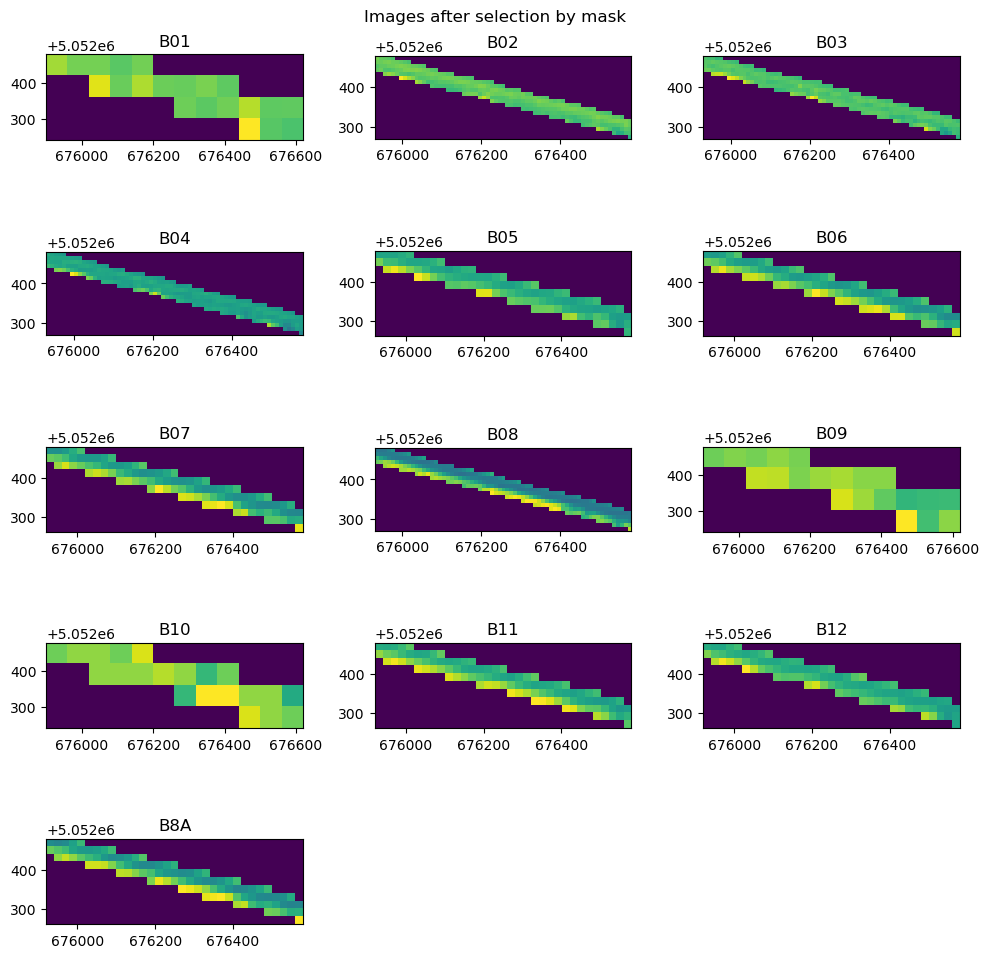

<Figure size 640x480 with 0 Axes>

In [175]:
import matplotlib.pyplot as plt
import rasterio as rio

num_images = len(clipped_dict)
num_columns = 3
num_rows = -(-num_images // num_columns)  # Ceiling division to ensure all images are accommodated

# Create subplots with specified number of rows and columns
vertical_padding = 2
fig, axs = plt.subplots(num_rows, num_columns, figsize=(10, vertical_padding*num_rows))

# Flatten the axs array if it's not already flat
if not isinstance(axs, (list, np.ndarray)):
    axs = [axs]

# Plot each image
for num, (key, value) in enumerate(clipped_dict.items()):
    src = rio.open(value)
    extent = [src.bounds[0], src.bounds[2], src.bounds[1], src.bounds[3]]
    row_index = num // num_columns
    col_index = num % num_columns
    axs[row_index, col_index].imshow(src.read(1), extent=extent)
    axs[row_index, col_index].set_title(key.split("_")[0])  # Optionally set title to image key

for i in range(num_images, num_rows*num_columns):
    fig.delaxes(axs.flatten()[i])
    
# Adjust layout
fig.tight_layout()
fig.suptitle("Images after selection by mask")
plt.show()
plt.savefig(os.path.join("plots", "snipped_bands_before_resize.png"))

## Resampling
As we can see in the images above, not all the bands have the same resolution. This will be a problem when it comes to stacking.

In [30]:
def save_raster_to_file(layer_path, raster, transform): 
    """Saves raster to tif -> for now the default crs is EPSG:32631
    Args:
        layer_path: String, where the file should be saved
        raster: numpy.ndarray containing our image information, should be a single layer
        transform: affine
    Returns:
        
    """
    new_dataset = rio.open(
        os.path.join(layer_path),
        'w',
        driver='GTiff',
        height=raster.squeeze().shape[0],
        width=raster.squeeze().shape[1],
        count=1,
        nodata=None,
        dtype=raster.dtype,
        transform=transform,
    )
    new_dataset.write(raster.squeeze(), 1)
    new_dataset.close()

high_res (11, 33) -> low_res(4, 12)


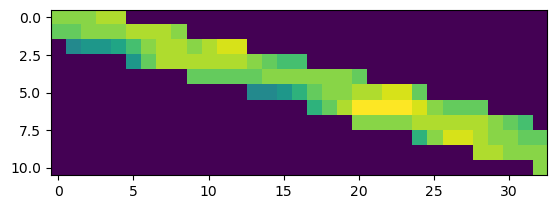

In [32]:
from src.utils import clean, resample
# resample and clean the data
data, trans = resample(clipped_dict.get("B07_path"), clipped_dict.get("B10_path"))
cleaned_data = clean(rio.open(clipped_dict.get("B07_path")).read(1).squeeze(), data)

## Creating path and new folder: 
folder_name = ((glob.glob("sisi/*")[0]).split("/")[1]).split(".")[0]
resampled_raster_location = os.path.join("resampled", folder_name)
if not os.path.exists(resampled_raster_location):
    os.makedirs(resampled_raster_location)
resampled_raster_name = "test.tif"

# saving raster to file
save_raster_to_file(os.path.join(resampled_raster_location, resampled_raster_name), cleaned_data, trans)

## plot the result
plt.imshow(cleaned_data)

In [129]:
def resample2(to_resize, reference, reference_geom):
    """Resamples a rasterio image (to_resize) to fit the reference image (reference)
    Args:
        reference: tuple
        to_resize: path to a tif, the one that will be resampled to fit reference
    Returns: 
        (numpy.ndarray, affine.Affine)
    """
    import rasterio as rio
    from rasterio.enums import Resampling
    import math

    
    low_res_img = rio.open(to_resize).read(1).squeeze()
    high_res = reference
    low_res = low_res_img.shape
    
    print(f"high_res {high_res} -> low_res{low_res}")
    width_upscale = high_res[0]/low_res[0]
    height_upscale = high_res[1]/low_res[1]
    
    with rio.open(to_resize) as dataset:
        data = dataset.read(
            out_shape=(
                dataset.count,
                reference[0],
                reference[1]
            ),
            resampling = Resampling.bilinear # Maybe other resampling methods work better
        ).squeeze()
    
        # scale image transform
        if reference_geom == None:
            transform = dataset.transform * dataset.transform.scale(
                (dataset.width / data.shape[-1]),
                (dataset.height / data.shape[-2])
            )
        else: 
            transform = reference_geom
    assert data.shape == high_res, f"Not resized to the correct dimension size. Target: {high_res}, Result: {data.shape}"
    return data, transform

In [156]:
# defining folder where rasters will be saved
folder_name = ((glob.glob("sisi/*")[0]).split("/")[1]).split(".")[0]
resampled_raster_location = os.path.join("resampled", folder_name)
cleaned_raster_location = os.path.join("cleaned", folder_name)
if not os.path.exists(resampled_raster_location):
    os.makedirs(resampled_raster_location)
if not os.path.exists(cleaned_raster_location):
    os.makedirs(cleaned_raster_location)

# choosing BO2 as the reference resolution
reference_name = "B03_path"
reference_res = rio.open(clipped_dict.get(reference_name)).read(1).squeeze().shape
for num, (key, value) in enumerate(clipped_dict.items()):
    reference_array = rio.open(clipped_dict.get(reference_name)).read(1)
    reference_geom = rio.open(clipped_dict.get(reference_name)).transform
    resampled_raster_name = (key.split("_"))[0]+".tif"
    print(resampled_raster_name)
    
    # first check to see if they have the same dimension
    with rio.open(value) as dataset:
        data = dataset.read(1).squeeze()
        if data.shape == reference_res:
            print("Already has the righ resolution, moving on.")
            save_raster_to_file(os.path.join(resampled_raster_location, resampled_raster_name), data, dataset.transform)
            save_raster_to_file(os.path.join(cleaned_raster_location, resampled_raster_name), data, dataset.transform)
        else: 
            print("Incompatible sizes, resizing")
            resampled_data, trans = resample2(clipped_dict.get(key), reference_res, reference_geom)
            # cleaning image
            cleaned_img = clean(reference_array, resampled_data)
            save_raster_to_file(os.path.join(cleaned_raster_location, resampled_raster_name), cleaned_img, trans)
            save_raster_to_file(os.path.join(resampled_raster_location, resampled_raster_name), resampled_data, trans)

B01.tif
Incompatible sizes, resizing
high_res (21, 65) -> low_res(4, 12)
B02.tif
Already has the righ resolution, moving on.
B03.tif
Already has the righ resolution, moving on.
B04.tif
Already has the righ resolution, moving on.
B05.tif
Incompatible sizes, resizing
high_res (21, 65) -> low_res(11, 33)
B06.tif
Incompatible sizes, resizing
high_res (21, 65) -> low_res(11, 33)
B07.tif
Incompatible sizes, resizing
high_res (21, 65) -> low_res(11, 33)
B08.tif
Already has the righ resolution, moving on.
B09.tif
Incompatible sizes, resizing
high_res (21, 65) -> low_res(4, 12)
B10.tif
Incompatible sizes, resizing
high_res (21, 65) -> low_res(4, 12)
B11.tif
Incompatible sizes, resizing
high_res (21, 65) -> low_res(11, 33)
B12.tif
Incompatible sizes, resizing
high_res (21, 65) -> low_res(11, 33)
B8A.tif
Incompatible sizes, resizing
high_res (21, 65) -> low_res(11, 33)


#### Plotting resampled images

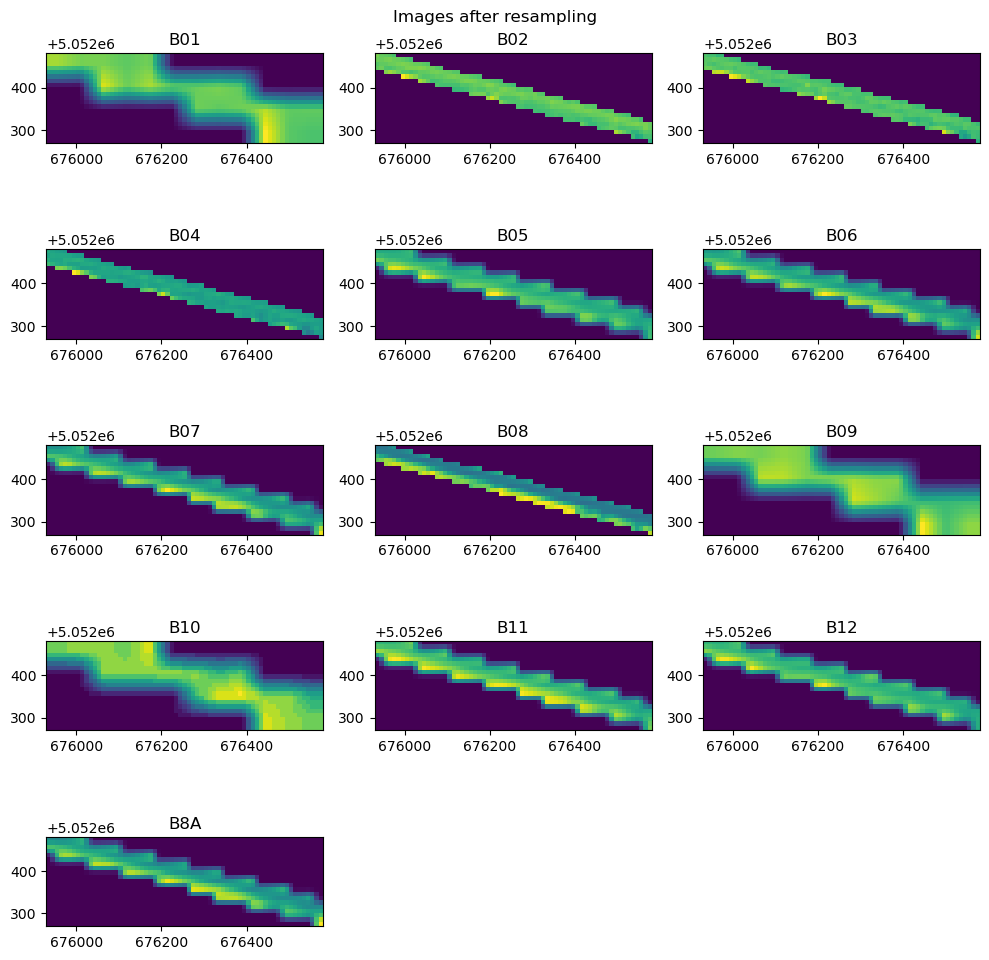

<Figure size 640x480 with 0 Axes>

In [173]:
import matplotlib.pyplot as plt
import rasterio as rio

folder_name = ((glob.glob("sisi/*")[0]).split("/")[1]).split(".")[0]
resampled_raster_location = os.path.join("resampled", folder_name, "*.tif")
to_plot = glob.glob(resampled_raster_location)

num_images = len(to_plot)
num_columns = 3
num_rows = -(-num_images // num_columns)  # Ceiling division to ensure all images are accommodated

# Create subplots with specified number of rows and columns
vertical_padding = 2
fig, axs = plt.subplots(num_rows, num_columns, figsize=(10, vertical_padding*num_rows))

# Flatten the axs array if it's not already flat
if not isinstance(axs, (list, np.ndarray)):
    axs = [axs]

# Plot each image
for num, path in enumerate(to_plot):
    src = rio.open(path)
    extent = [src.bounds[0], src.bounds[2], src.bounds[1], src.bounds[3]]
    row_index = num // num_columns
    col_index = num % num_columns
    axs[row_index, col_index].imshow(src.read(1), extent=extent)
    axs[row_index, col_index].set_title(path.split("/")[-1].replace('.tif', '')) # Optionally set title to image key

for i in range(num_images, num_rows*num_columns):
    fig.delaxes(axs.flatten()[i])
    
# Adjust layout
fig.tight_layout()
fig.suptitle("Images after resampling")
plt.show()
plt.savefig(os.path.join("plots", "images_after_resampling.png"))

#### Plotting resampled images

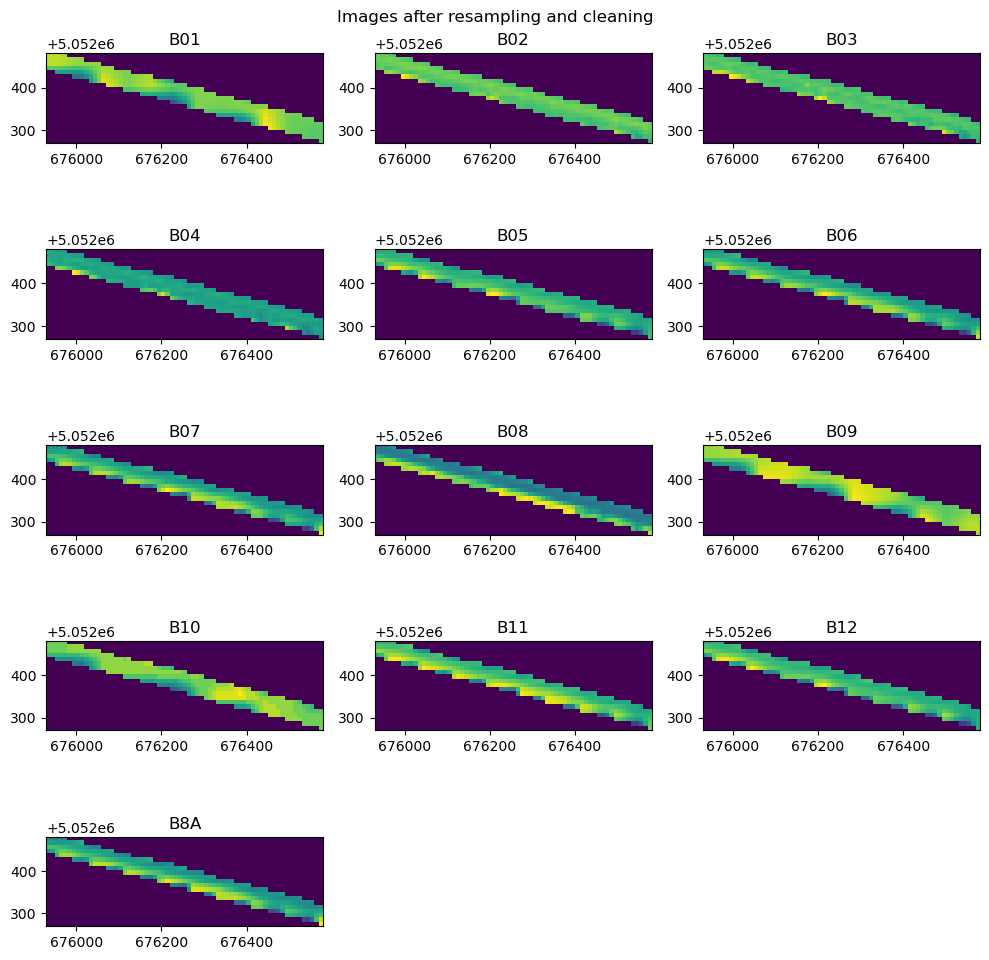

<Figure size 640x480 with 0 Axes>

In [174]:
import matplotlib.pyplot as plt
import rasterio as rio

folder_name = ((glob.glob("sisi/*")[0]).split("/")[1]).split(".")[0]
raster_location = os.path.join("cleaned", folder_name, "*.tif")
to_plot = glob.glob(raster_location)

num_images = len(to_plot)
num_columns = 3
num_rows = -(-num_images // num_columns)  # Ceiling division to ensure all images are accommodated

# Create subplots with specified number of rows and columns
vertical_padding = 2
fig, axs = plt.subplots(num_rows, num_columns, figsize=(10, vertical_padding*num_rows))

# Flatten the axs array if it's not already flat
if not isinstance(axs, (list, np.ndarray)):
    axs = [axs]

# Plot each image
for num, path in enumerate(to_plot):
    src = rio.open(path)
    extent = [src.bounds[0], src.bounds[2], src.bounds[1], src.bounds[3]]
    row_index = num // num_columns
    col_index = num % num_columns
    axs[row_index, col_index].imshow(src.read(1), extent=extent)
    axs[row_index, col_index].set_title(path.split("/")[-1].replace('.tif', ''))  # Optionally set title to image key

for i in range(num_images, num_rows*num_columns):
    fig.delaxes(axs.flatten()[i])
    
# Adjust layout
fig.tight_layout()
fig.suptitle("Images after resampling and cleaning")
plt.show()
plt.savefig(os.path.join("plots", "images_after_cleaning.png"))

# ANNEX

# Snipping raster by mask
There are 14 bands in Sentinel 2 data

EPSG:32631


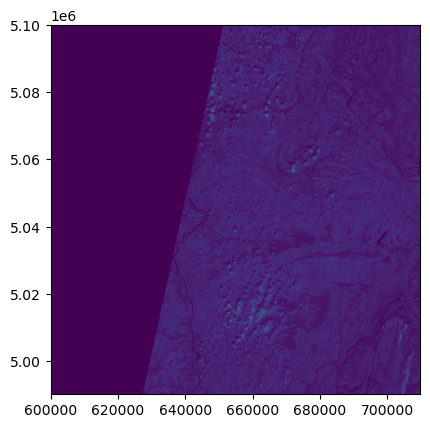

In [17]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots()
src = rio.open(l[6])
extent = [src.bounds[0], src.bounds[2], src.bounds[1], src.bounds[3]]
#extent = [src.bounds[1], src.bounds[3], src.bounds[0], src.bounds[2]]
# axs = rio.plot.show(src.read(1), extent=extent, cmap='viridis')
plt.imshow(src.read(1), extent=extent)

print(src.crs)
gdf.plot(ax=axs)
# ax
plt.show()

## Adding mask layer
Here we are applying the mask band by band.

|Function|Explanation|
|---|---|
|all_touched|also keeps the pixels that are touched by the geometry, removes holes from layers with less spatial resolution|
|squeeze|Removes unwanted dimensions in a numpy array ex: (1, 200, 200) -> (200, 200)

[Link](https://rasterio.readthedocs.io/en/latest/topics/resampling.html) to resampling method using rasterio

In [19]:
from rasterio import mask

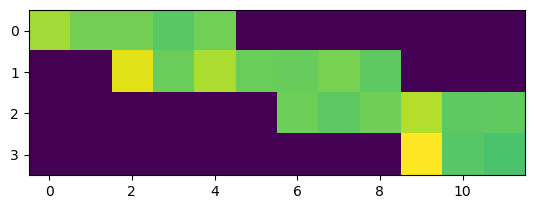

In [45]:
band0, band0_transform = mask.mask(
    rio.open(l[0]),
    gdf.geometry,
    crop=True,
    all_touched=True # also keeps the pixels that are touched
)

band1, band1_transform = rio.mask.mask(
    rio.open(l[1]),
    gdf.geometry,
    crop=True,
    all_touched=True # also keeps the pixels that are touched
)
band2, band2_transform = rio.mask.mask(
    rio.open(l[2]),
    gdf.geometry,
    crop=True,
    all_touched=True # also keeps the pixels that are touched
)
plt.imshow(band0.squeeze())

### Saving to file
Saving snipped satellite tiles to file

In [91]:
band0.shape

(1, 4, 12)

In [118]:
# we start by creating a new set of folders: Snipped/<satellite data name>/my_image.tif
folder_name = ((glob("sisi/*")[0]).split("/")[1]).split(".")[0]
snipped_raster_location = os.path.join("Snipped", folder_name)
if not os.path.exists(snipped_raster_location):
    os.makedirs(snipped_raster_location)
# Now we write the raster into this new folder
layer_name = "band0.tif"

new_dataset = rio.open(
    os.path.join("Snipped", folder_name, layer_name),
    'w',
    driver='GTiff',
    height=band0.squeeze().shape[0],
    width=band0.squeeze().shape[1],
    count=1,
    dtype=band0.dtype,
    transform=band0_transform,
)
new_dataset.write(band0.squeeze(), 1)
new_dataset.close()

### Opening saved file

None


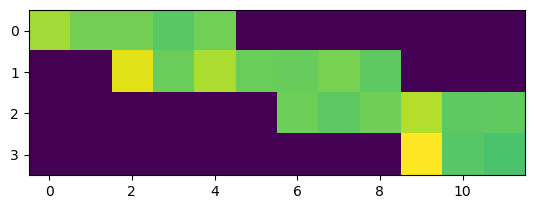

In [119]:
src = rio.open(os.path.join("Snipped", folder_name, layer_name))
extent = [src.bounds[0], src.bounds[2], src.bounds[1], src.bounds[3]]
plt.imshow(src.read(1))

print(src.crs)
gdf.plot(ax=axs)
# ax
plt.show()

## Staking
Now that we can apply the mask layer on each band, we need to stack each band onto each other

In [21]:
band0 = band0.squeeze()
band0.shape

(4, 12)

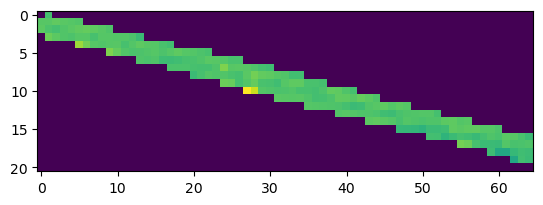

In [22]:
from rasterio import mask
clipped_bands = []
for num, src in enumerate(srcs): 
    out_image, out_transform = rio.mask.mask(
	    src, 
	    gdf.geometry, 
	    crop=True
	)
    clipped_bands.append(np.squeeze(out_image))
clipped_stacked = np.stack(clipped_bands, axis=0)
plt.imshow(clipped_stacked[0, :, :])

In [23]:
import os
from glob import glob
import matplotlib.pyplot as plt
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

<Axes: >

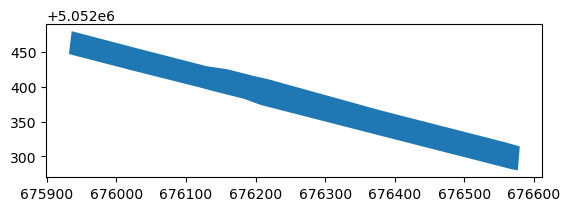

In [24]:
gdf.plot()